<h1> Trained Model Validation </h1>
<h2> Actual vs Predicted (PM2.5 line plots) <br>
Error trends</h2>

In [2]:
# !pip install pymongo

In [4]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
load_dotenv()

True

In [10]:
# 1. Configuration & Model Loading
MODEL_PATH = "models/aqi_multi_output_model.pkl"
MONGO_URI = os.getenv("MONGO_URI")

print("Load saved model and metadata...")
saved_data = joblib.load(MODEL_PATH)
model = saved_data["model"]
features = saved_data["features"]

Load saved model and metadata...


In [12]:
# 2. Load Fresh Data from MongoDB
def fetch_test_data():
    client = MongoClient(MONGO_URI)
    db = client["aqi_predictor"]
    collection = db["feature_store"]

    # Get recent records to check performance
    cursor = collection.find({}, {"_id": 0})
    df = pd.DataFrame(list(cursor))

    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"])
        df = df.sort_values("datetime")

    return df

df = fetch_test_data()
df_clean = df.dropna()

In [14]:
# Generate Predictions
split_idx = int(len(df) * 0.8)
df_test = df.iloc[split_idx:].copy()

# This removes the very end of the dataset where future targets don't exist
df_test = df_test.dropna(subset=features + ["target_h24", "target_h48", "target_h72"])

X_unseen = df_test[features]
y_unseen = df_test[["target_h24", "target_h48", "target_h72"]]
unseen_timestamps = df_test["datetime"].values

print(f"Run inference on {len(X_unseen)} samples")
y_pred = model.predict(X_unseen)

Run inference on 3591 samples


In [16]:
# Create Comparison Visualization
def plot_comparisons(actual, pred, timestamps):
    horizons = ["24h", "48h", "72h"]
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    num_samples = len(actual)
    plot_limit = min(200, num_samples)

    for i, h in enumerate(horizons):
        # Calculate metrics for the unseen slice
        mae = mean_absolute_error(actual[:, i], pred[:, i])
        r2 = r2_score(actual[:, i], pred[:, i])

        # Plot only the last 'plot_limit' samples
        axes[i].plot(timestamps[-plot_limit:], actual[-plot_limit:, i],
                     label=f"Actual {h}", color="black", alpha=0.6)
        axes[i].plot(timestamps[-plot_limit:], pred[-plot_limit:, i],
                     label=f"Predicted {h}", color="red", linestyle="--")

        axes[i].set_title(f"AQI Forecast: {h} Horizon (MAE: {mae:.2f}, R2: {r2:.3f})")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.xlabel("Timeline")
    plt.tight_layout()
    plt.show()

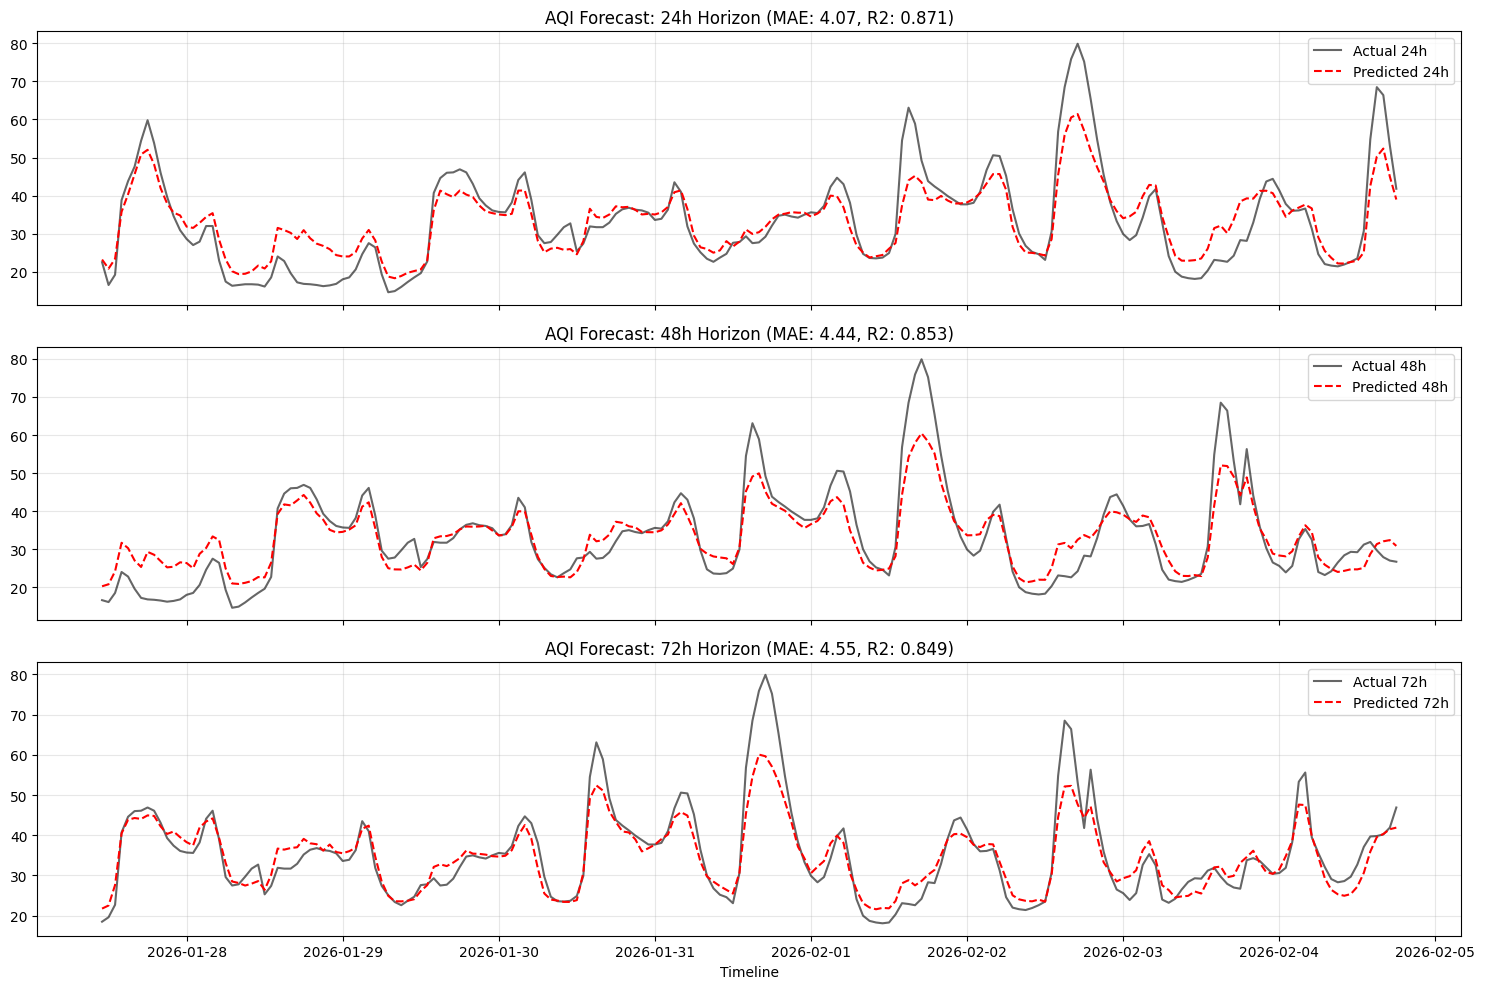

In [18]:
# Run the plot
plot_comparisons(y_unseen.values, y_pred, unseen_timestamps)